In [109]:
# A simple monte carlo simulation of an NHL season. W/L is determined by fixed probabilities rather than a fit distribution
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt


In [2]:
# Organize data in a way that might be helpful and initialize some things

df = pd.read_csv("NHL_20132014.csv")           #This has game data and is mostly what is used in the toy simulation
df2 = pd.read_csv("NHL_20132014_processed.csv")

# For each team name give them a W-L-T initial array. For overtime to happen win+loss must sum to less than 1.

prob = [0.5, 0.4, 0.55]  # Probablility of [Home win, home loss, home OT win]


# Lets just mess around with some brute forcing. Inelegant but I can't do anything else until the internet is back.

teams = ['ANA', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL', 'DAL', 'DET', 'EDM', 'FLA', 'LAK', 'MIN', 'MTL', 'NJD', 'NSH', 'NYI', 'NYR', 'OTT', 'PHI', 'PHX', 'PIT', 'SJS', 'STL', 'TBL', 'TOR', 'VAN', 'WPG', 'WSH']

In [16]:
# Single season. Here we make a function which simulates a single season. Right now,
# we input prob of winning by hand. This is fixed for all teams. Later we will add in a function to this guy which 
# Later we will add in a function to this guy which uses poissonto find goal distribtion scored by each team in a given matchup. Odds of winning will be found from this 
def season(schedule, one_hot, prob):
    home, away = schedule['home'], schedule['away']
    teams = one_hot.columns[0:-2]
    games = len(schedule)
    win = prob[0]
    loss = prob[1]
    win_OT = prob[2]
    team_no = len(teams)
    score = np.zeros((len(teams), 3)) 
    
    for i in range(0, games):
        roll = random.rand()
        
        home_index = one_hot.columns.get_loc(home[i])    # Using get_loc on a dataframe is much faster!
        away_index = one_hot.columns.get_loc(away[i])    # Factor of 6-8 decrease in computation time. 
        
        
        
        #for j in range(0, team_no):      # This little piece here matches the name to teams_label so that
        #    if home[i] == teams[j]:         # I can extract an index and use that index for teams 
        #        home_index = j                    # NOTE: This will not work if teams and teams_label are different in their order                 
        #    if away[i] == teams[j]:         # or number. Fix this once you've got internet but for now it works 
        #        away_index = j           # NOTE: This might be too slow. Try alternatives
    
        if roll <= win:
            score[home_index] = score[home_index]+[1,0,0]                  # Home regulation win
            score[away_index] = score[away_index]+[0,1,0]
        elif roll > win and roll <= win+loss:
            score[home_index] = score[home_index]+[0,1,0]                   # Away regulation win
            score[away_index] = score[away_index]+[1,0,0]
        else:
            roll_OT = random.rand()
            if roll_OT <= win_OT:
                score[home_index] = score[home_index]+[1,0,0]                  # Home OT win
                score[away_index] = score[away_index]+[0,0,1]
            else: 
                score[home_index] = score[home_index]+[0,0,1]                   # Away OT win
                score[away_index] = score[away_index]+[1,0,0]
    return score

In [30]:
# Calculated and display points
def sum_points(score):
    pts = np.zeros(len(score))
    j = 0
    for i in score:
        pts[j] = sum(i*[2,0,1])
        j = j+1
    return pts

In [17]:
# Run the simulation one time
test = season(df, df2, prob)

# This block is a sanity check. Every team should have played 82 games. If not, something is wrong
for i in range(0, len(test)):
    total = sum(test[i])
    if total != 82:
        print('FALSE. GO BACK AND WORK OUT THE PROBLEM')        
        

In [18]:
# Get the points and print something nice
pts = points(test)
for i in range(0, len(teams)):
    print(teams[i], pts[i])

ANA 80.0
BOS 96.0
BUF 87.0
CAR 81.0
CBJ 77.0
CGY 88.0
CHI 78.0
COL 101.0
DAL 83.0
DET 77.0
EDM 79.0
FLA 90.0
LAK 96.0
MIN 77.0
MTL 79.0
NJD 83.0
NSH 87.0
NYI 77.0
NYR 84.0
OTT 91.0
PHI 97.0
PHX 99.0
PIT 78.0
SJS 89.0
STL 94.0
TBL 88.0
TOR 93.0
VAN 83.0
WPG 112.0
WSH 90.0


In [152]:
%%time
# Now that we have a single season working we want to monte carlo this and find the mean and std of points across 
# something like 10,000 simulations. Test cases: 10,000 is a bit time consuming. Oh no! Add in a timer to work out
# improvements

n = 100
result_matrix = np.zeros([n,len(teams)]) # Create an n x #teams matrix. Each season results will stored on a single row of this matrix 

for i in range(0,n): 
    score = season(df, df2, prob)
    result_matrix[i] = sum_points(score)

mean_points = np.zeros([1, len(teams)])    
std_points = np.zeros([1, len(teams)])


for i in range(0, len(teams)):
    mean_points[:,i] = np.transpose(np.mean(result_matrix[:,i])) # Do a transposition to make the array make more sense in my head
    std_points[:,i] = np.transpose(np.std(result_matrix[:,i]))
#print(mean_points)
#print(std_points)
#print(np.mean(mean_points), np.mean(std_points))   

Wall time: 5.66 s


(70.0, 110.0)

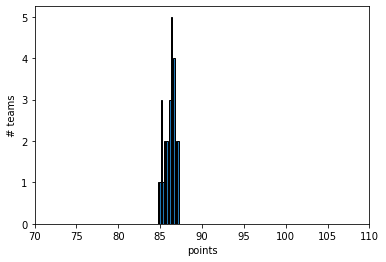

In [153]:
# Test out the convergence of the Monte Carlo by looking at some histograms.
# By increasing n, the distribution of points tightens up among the league mean. In the case where all teams have
# equal probability of winning, this is what we expect. Note: std. of points for a single team seems to increase slightly
# with n but saturates around 9. By looking at the histogram, we see that std. across teams tightens up dramatically with n. 
fig = plt.figure()
plt.hist(np.transpose(mean_points), 15, ec = 'black')
plt.ylabel('# teams')
plt.xlabel('points')
plt.xlim([70,110])

In [175]:
# Now that we've got some testing out of the way, lets make a monte carlo function

def monte_carlo(n, schedule, one_hot, num_teams, prob):
    result_matrix = np.zeros([n, num_teams]) # Create an n x #teams matrix. Each season results will stored on a single row of this matrix 

    for i in range(0,n): 
        score = season(schedule, one_hot, prob)
        result_matrix[i] = sum_points(score)

    mean_points = np.zeros([num_teams, 1])    
    std_points = np.zeros([num_teams, 1])


    for i in range(0, num_teams):
        mean_points[i] = np.mean(result_matrix[:,i]) # Do a transposition to make the array make more sense in my head
        std_points[i] = np.std(result_matrix[:,i])
    return mean_points, std_points
    

ANA: [85.6]
BOS: [87.2]
BUF: [83.7]
CAR: [85.3]
CBJ: [89.3]
CGY: [89.5]
CHI: [87.4]
COL: [91.3]
DAL: [89.6]
DET: [80.8]
EDM: [89.2]
FLA: [83.8]
LAK: [85.5]
MIN: [81.6]
MTL: [85.3]
NJD: [83.7]
NSH: [86.4]
NYI: [84.6]
NYR: [87.5]
OTT: [79.3]
PHI: [84.4]
PHX: [85.3]
PIT: [89.9]
SJS: [81.7]
STL: [86.7]
TBL: [87.5]
TOR: [85.7]
VAN: [87.4]
WPG: [83.6]
WSH: [91.4]


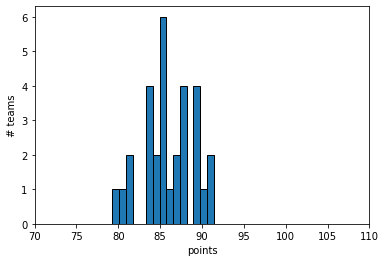

In [184]:
# Run a monte carlo simulation of n seasons, report mean points and standard deviation

n = 10
mean_points, std_points = monte_carlo(n, df, df2, len(teams), prob)

fig = plt.figure()
plt.hist(mean_points, 15, ec = 'black')
plt.ylabel('# teams')
plt.xlabel('points')
plt.xlim([70,110])

for i in range(0, len(teams)):
    print(f"{teams[i]}: {mean_points[i]}")

30